<a href="https://colab.research.google.com/github/Maverick29rus/homework/blob/master/%229%20%D0%9F%D0%B5%D1%80%D0%B2%D0%B0%D1%8F%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Краткая история нейронных сетей. Знакомство с многослойным персептроном](https://colab.research.google.com/drive/1-FEYLgNSN5kJyAOoaW9dOhDUABU8VJlc)
2. [Математический аппарат обучения нейронных сетей](https://colab.research.google.com/drive/1FtyyBXYq9FaOEknvu4ghim-ejuO_3aIZ)
3. [Обучение многослойного персептрона в TensorFlow (Практика)](https://colab.research.google.com/drive/1Q8ioc9pkkaqGravu37C7jKw9OaG7cNL0)
4. Домашняя работа

Используя модель обучения многослойного персептрона из практической части урока (9.3), выполните следующее:

1. Увеличьте число слоев до 4-х и сравните время обучения модели и точность на тестовой выборке.
2. В качестве датасета использовать любой из наборов данных TensorFlow. Обучить модель. Добейтесь результата распознования более 85% на тестовой выборке. [Датасеты на выбор](https://www.tensorflow.org/datasets/overview). Используйте датасет отличный от MNIST, который был в уроке.

Для прохождения урока достаточно решить первое задание.

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
# Установим по умолчанию размер фигуры для Matplotlib по умолчанию.
matplotlib.rcParams['figure.figsize'] = [9, 6]


#Загрузка данных

In [6]:
train_data, val_data, test_data = tfds.load("fashion_mnist",
                                            split=['train[6000:]',
                                                   'train[0:6000]',
                                                   'test'],
                                            batch_size=128,
                                            as_supervised=True
                                            )


#Визуализируем примеры

In [7]:
class_names = ['Футболка / топ', "Брюки", "Свитер", "Платье",
               "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
               "Ботинок"]


Размерность исходных данных: (1500, 28, 28, 1)
Размерность данных после сжатия: (1500, 28, 28)


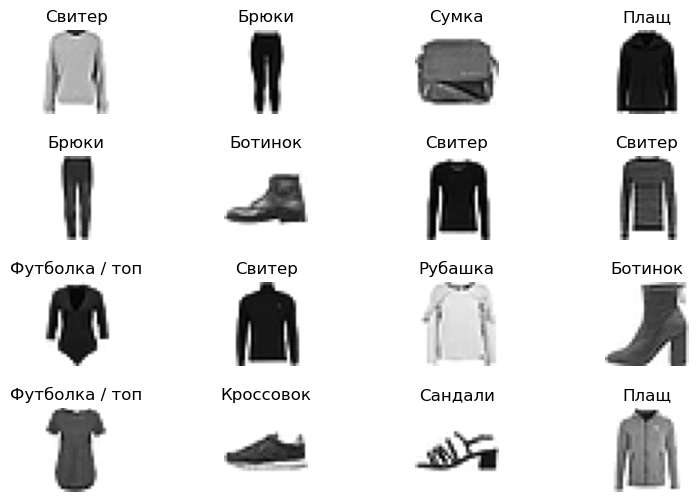

In [8]:
# Взять все одним батчем и выбрать его для визуализации
x_viz, y_viz = tfds.load("fashion_mnist",
                         split=['train[:1500]'],
                         batch_size=-1,
                         as_supervised=True)[0]
print('Размерность исходных данных:', x_viz.shape)
# метод сжатия размерности, исключаем данные по оси с индексом 3
x_viz = tf.squeeze(x_viz, axis=3)
print('Размерность данных после сжатия:', x_viz.shape)

for i in range(16):  # Выводим 16 картинок из датасета
    plt.subplot(4, 4, 1+i)
    plt.axis('off')
    # отображение массива numpy как картинки; cmap - карта цветов, используем серую 'gray'
    plt.imshow(x_viz[i], cmap='gray_r')
    plt.title(class_names[y_viz[i]])
    # Отступы по ширине и высоте между картинками
    plt.subplots_adjust(hspace=.5, wspace=.5)


Построим распределение цифр в обучающей выборке, чтобы убедиться, что каждый класс равномерно представлен в наборе данных.

Text(0.5, 1.0, 'Распределение цифр в fashion_mnist')

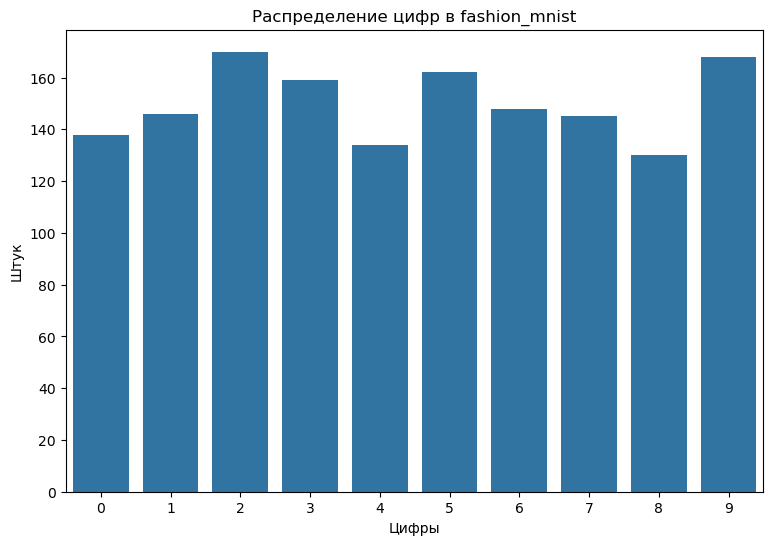

In [9]:
sns.countplot(x=y_viz.numpy())
plt.xlabel('Цифры')
plt.ylabel('Штук')
plt.title("Распределение цифр в fashion_mnist")


#Предобработка данных

In [10]:
# Функция изменения формы и масштабирования данных
def preprocess(x, y):
    # reshape - изменяет форму данных
    # -1 - значит сохранить форму для заданного индекса матрицы, равносильно указать 1500
    x = tf.reshape(x, shape=(-1, 784))
    # Масштабируем данные
    x = x/255
    return x, y


# map выполняет функцию preprocess для каждого элемента данных, к которым применяется
train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)


# Создание модели

## Функция инициализации Ксавье

In [11]:
def xavier_init(shape):
    # Вычисляем значения инициализации xavier для весовой матрицы
    in_dim, out_dim = shape

    # Задаем диапазон инициализации весов по схеме Ксавье
    xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))

    # Возвращаем тензор с равномерно распределенными случайными величинами в указанном интервале.
    weight_vals = tf.random.uniform(shape=(in_dim, out_dim),
                                    minval=-xavier_lim, maxval=xavier_lim)
    return weight_vals


## Полносвязанный слой

In [12]:
class DenseLayer(tf.Module):

    def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
        # Инициализация размеров и функции активации
        self.out_dim = out_dim  # Определяем размерность выходов
        self.weight_init = weight_init  # Инициализируем веса
        self.activation = activation  # Задаем функцию активации
        self.built = False

    @tf.function  # Декоратор, который переносит вычисления на уровень графа TensorFlow
    def __call__(self, x):
        if not self.built:  # Если запущен первый раз проводим инициализацию
            # Вывод входного измерения на основе первого вызова
            self.in_dim = x.shape[1]
            # Инициализация весов и смещений
            # Объявление тензорных переменных
            self.w = tf.Variable(self.weight_init(
                shape=(self.in_dim, self.out_dim)))
            # Объявление тензорных переменных
            self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
            self.built = True  # Инициализация пройдена
        # Вычисление прямого прохода
        y = tf.add(tf.matmul(x, self.w), self.b)  # уравнение персептрона
        # Применение функции активации к уравнению персептрона
        return self.activation(y)


## Класс для модели MLP

In [13]:
class MLP(tf.Module):

    def __init__(self, layers):
        self.layers = layers

    @tf.function  # Декоратор, который переносит вычисления на уровень графа TensorFlow
    def __call__(self, x, preds=False):
        # Последовательное выполнение слоев модели
        for layer in self.layers:
            x = layer(x)
        return x


## Инициализируем модель MLP

In [14]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
hidden_layer_3_size = 300
output_size = 10

# Создание модели нейронной сети с 3 слоями
mlp_model_3 = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

# Создание модели нейронной сети с 4 слоями
mlp_model_4 = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_3_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])


## Функция потерь перекрестной энтропии

In [15]:
def cross_entropy_loss(y_pred, y):
    # Вычисление перекрестной энтропии с помощью разреженной операции
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=y_pred)
    return tf.reduce_mean(sparse_ce)  # аналог np.mean для тензоров


## Функция вычисления точности

In [16]:
def accuracy(y_pred, y):
    # Вычисляем точность после извлечения предсказаний класса
    # возвращает индекс максимального элемента
    class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
    is_equal = tf.equal(y, class_preds)  # сравнение тензорных значений
    # аналог np.mean для тензоров
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))


## Алгоритм оптимизации

In [17]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
        # Инициализируем параметры оптимизатора и резервируем переменные
        self.beta_1 = beta_1  # гиперпараметр
        self.beta_2 = beta_2  # гиперпараметр
        self.learning_rate = learning_rate  # шаг обучения
        self.ep = ep  # Эпсилон - предотвращает деление на ноль, слабо влияет на обучение
        self.t = 1.
        self.v_dvar, self.s_dvar = [], []
        self.built = False

    def apply_gradients(self, grads, vars):
        # Инициализируем переменные при первом вызове
        if not self.built:
            for var in vars:
                v = tf.Variable(tf.zeros(shape=var.shape))
                s = tf.Variable(tf.zeros(shape=var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
            self.built = True
        # Обновите переменные модели с учетом их градиентов
        for i, (d_var, var) in enumerate(zip(grads, vars)):
            self.v_dvar[i].assign(
                self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
            self.s_dvar[i].assign(
                self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
            v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
            s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
            var.assign_sub(self.learning_rate*(v_dvar_bc /
                           (tf.sqrt(s_dvar_bc) + self.ep)))
        self.t += 1.
        return


## Цикл обучения

Теперь напишем пользовательский цикл обучения, который обновляет параметры MLP с помощью мини-пакетного градиентного спуска.

In [18]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
    # Обновляем состояние модели с учетом пакета данных
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)  # Предсказываем значение с текущими весами
        batch_loss = loss(y_pred, y_batch)  # Оцениваем ошибку на текущих весах
    batch_acc = acc(y_pred, y_batch)  # Оцениваем точность на текущих весах
    grads = tape.gradient(batch_loss, model.variables)  # Вычисляем градиенты
    # Обновляем переменные с учетом полученных градиентов
    optimizer.apply_gradients(grads, model.variables)
    # Возвращаем ошибку и точность на основе заданного пакета
    return batch_loss, batch_acc


def val_step(x_batch, y_batch, loss, acc, model):
    # Оцениваем модель на основе заданного пакета валидационных данных без обучения на текущих весах
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
    batch_acc = acc(y_pred, y_batch)
    return batch_loss, batch_acc


In [19]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
    # Инициализация структур данных
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # Отформатируем тренировочный цикл и начнем обучение
    for epoch in range(epochs):
        batch_losses_train, batch_accs_train = [], []
        batch_losses_val, batch_accs_val = [], []

        # Выполняем итерацию по обучающим данным
        for x_batch, y_batch in train_data:
            # Вычисляем градиенты и обновляем параметры модели
            batch_loss, batch_acc = train_step(
                x_batch, y_batch, loss, acc, mlp, optimizer)
            # Следим за результатами обучения на пакетном уровне
            batch_losses_train.append(batch_loss)
            batch_accs_train.append(batch_acc)

        # Повторяем процедуру проверки данных
        for x_batch, y_batch in val_data:
            batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
            batch_losses_val.append(batch_loss)
            batch_accs_val.append(batch_acc)

        # Следим за производительностью модели на уровне эпохи
        train_loss, train_acc = tf.reduce_mean(
            batch_losses_train), tf.reduce_mean(batch_accs_train)
        val_loss, val_acc = tf.reduce_mean(
            batch_losses_val), tf.reduce_mean(batch_accs_val)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Эпоха: {epoch}")
        print(f"Обучающая ошибка: {train_loss:.3f}, 
              Обучающая точность: {train_acc:.3f}"
              )
        print(f"Валидационная ошибка: {val_loss:.3f}, 
              Валидационная точность: {val_acc:.3f}"
              )
    return train_losses, train_accs, val_losses, val_accs


#Тренируем модель MLP в течение 10 эпох с размером пакета 128

In [20]:
from time import time
start = time()
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model_3,
                                                             train_data, val_data, 
                                                             loss=cross_entropy_loss, 
                                                             acc=accuracy, 
                                                             optimizer=Adam(), 
                                                             epochs=10
                                                             )
learning_time_3 = time()-start


Эпоха: 0
Обучающая ошибка: 0.479, Обучающая точность: 0.827
Валидационная ошибка: 0.403, Валидационная точность: 0.854
Эпоха: 1
Обучающая ошибка: 0.351, Обучающая точность: 0.871
Валидационная ошибка: 0.330, Валидационная точность: 0.883
Эпоха: 2
Обучающая ошибка: 0.314, Обучающая точность: 0.884
Валидационная ошибка: 0.316, Валидационная точность: 0.887
Эпоха: 3
Обучающая ошибка: 0.290, Обучающая точность: 0.892
Валидационная ошибка: 0.303, Валидационная точность: 0.891
Эпоха: 4
Обучающая ошибка: 0.270, Обучающая точность: 0.899
Валидационная ошибка: 0.312, Валидационная точность: 0.887
Эпоха: 5
Обучающая ошибка: 0.252, Обучающая точность: 0.905
Валидационная ошибка: 0.303, Валидационная точность: 0.894
Эпоха: 6
Обучающая ошибка: 0.236, Обучающая точность: 0.911
Валидационная ошибка: 0.309, Валидационная точность: 0.895
Эпоха: 7
Обучающая ошибка: 0.226, Обучающая точность: 0.914
Валидационная ошибка: 0.323, Валидационная точность: 0.892
Эпоха: 8
Обучающая ошибка: 0.215, Обучающая точн

# Оценка производительности

Начнем с написания функции построения графика, чтобы визуализировать потери и точность модели во время обучения.

In [21]:
def plot_metrics(train_metric, val_metric, metric_type):
    # Визуализация метрик в зависимости от эпох обучения
    plt.figure()
    plt.plot(range(len(train_metric)), 
             train_metric,
             label=f"{metric_type} на обучающей выборке")
    plt.plot(range(len(val_metric)), 
             val_metric, 
             label=f"{metric_type} на валидационной выборке")
    plt.xlabel("Эпохи")
    plt.ylabel(metric_type)
    plt.legend()
    plt.title(f"{metric_type} от эпохи")


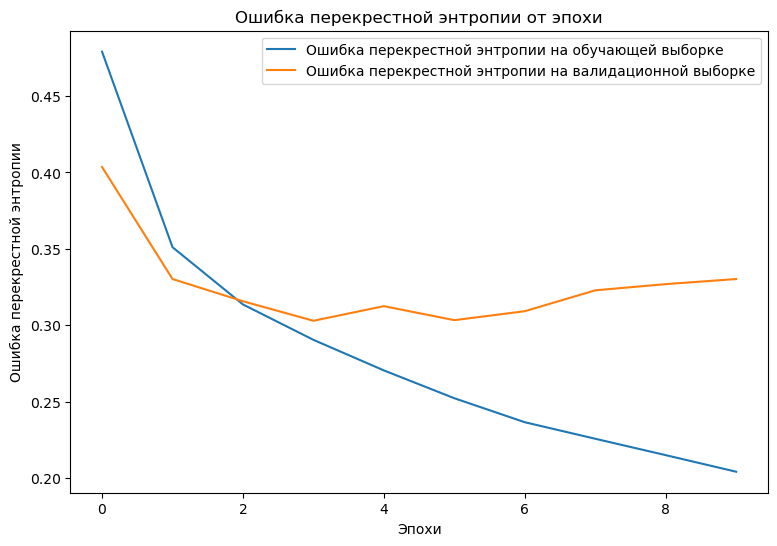

In [22]:
plot_metrics(train_losses, val_losses, "Ошибка перекрестной энтропии")


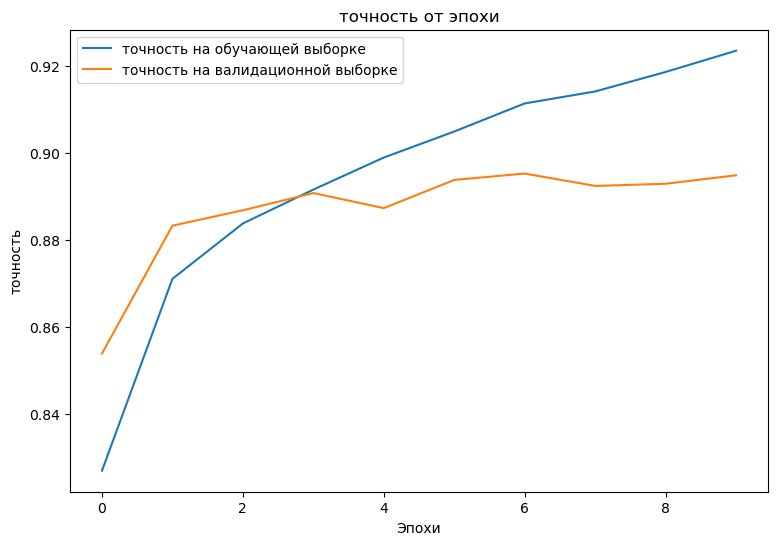

In [23]:
plot_metrics(train_accs, val_accs, "точность")


# Сохранение и загрузка модели

Создадим модуль экспорта, который принимает необработанные данные и выполняет следующие операции:
- Предобработка данных
- Прогнозирование вероятности
- Прогнозирование класса


In [24]:
class ExportModule(tf.Module):
    def __init__(self, model, preprocess, class_pred):
        # Инициализация функций предобработки и постобработки
        self.model = model
        self.preprocess = preprocess
        self.class_pred = class_pred

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None],
                                                dtype=tf.uint8)])
    def __call__(self, x):
        # Запускаем модуль экспорта для получения новых точек данных
        x = self.preprocess(x)
        y = self.model(x)
        y = self.class_pred(y)
        return y


In [25]:
def preprocess_test(x):
    # Модуль экспорта принимает необработанные и немаркированные данные
    x = tf.reshape(x, shape=[-1, 784])
    x = x/255
    return x


def class_pred_test(y):
    # Сгенерируем прогнозы классов на основе выходных данных MLP
    return tf.argmax(tf.nn.softmax(y), axis=1)


In [26]:
mlp_model_export = ExportModule(model=mlp_model_3,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)


In [27]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)


INFO:tensorflow:Assets written to: /var/folders/1y/bx2jjy_d3gx03cp1vkc6cbyh0000gp/T/tmp_39e44ld/mlp_model_export/assets


INFO:tensorflow:Assets written to: /var/folders/1y/bx2jjy_d3gx03cp1vkc6cbyh0000gp/T/tmp_39e44ld/mlp_model_export/assets


# Проверка производительности

Загрузим сохраненную модель и проверим ее производительность на невидимых ранее моделью тестовых данных.


In [28]:
mlp_loaded_3 = tf.saved_model.load(save_path)


In [29]:
def accuracy_score(y_pred, y):
    # Общая функция точности
    is_equal = tf.equal(y_pred, y)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))


x_test, y_test = tfds.load("fashion_mnist", split=[
                           'test'], batch_size=-1, 
                           as_supervised=True)[0]
test_classes = mlp_loaded_3(x_test)
test_acc_3 = accuracy_score(test_classes, y_test)
print(f"Точность на тестовой выборке: {test_acc_3:.3f}")


Точность на тестовой выборке: 0.883


Модель отлично справляется с классификацией написанных от руки цифр в обучающем наборе данных, а также хорошо обобщает невидимые ранее данные. Теперь проверим точность модели по классам, чтобы обеспечить хорошую производительность для каждой цифры.

In [30]:
print("Точность с разбивкой по цифрам :")
print("---------------------------")
label_accs = {}
for label in range(10):
    label_ind = (y_test == label)
    # extract predictions for specific true label
    pred_label = test_classes[label_ind]
    labels = y_test[label_ind]
    # compute class-wise accuracy
    label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
    print(f"Цифра {label_accs[key]}: {key:.3f}")


Точность с разбивкой по цифрам :
---------------------------
Цифра 6: 0.595
Цифра 4: 0.766
Цифра 2: 0.872
Цифра 0: 0.876
Цифра 3: 0.882
Цифра 9: 0.945
Цифра 5: 0.960
Цифра 7: 0.973
Цифра 8: 0.984


Похоже, что модель испытывает трудности с некоторыми цифрами немного больше, чем с другими, что довольно часто встречается во многих задачах многоклассовой классификации. В качестве заключительного упражнения построим матрицу ошибок предсказаний модели и соответствующих ей истинных меток, чтобы получить больше информации на уровне класса. В Sklearn и seaborn есть функции для генерации и визуализации матриц ошибок.

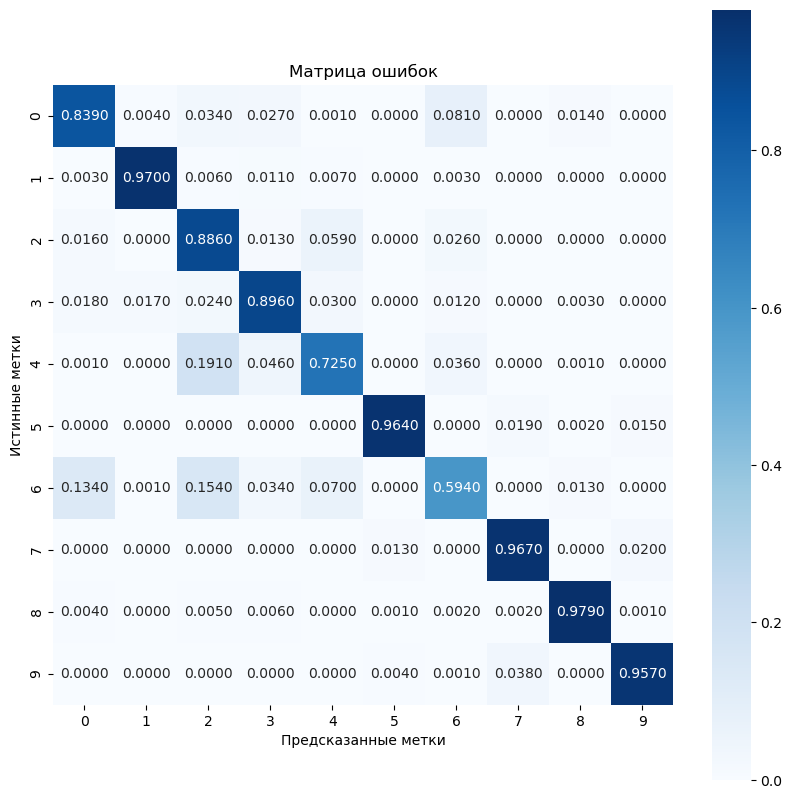

In [ ]:
import sklearn.metrics as sk_metrics


def show_confusion_matrix(test_labels, test_classes):
    # Вычисление матрицы ошибок и ее нормализация
    plt.figure(figsize=(10, 10))
    confusion = sk_metrics.confusion_matrix(test_labels.numpy(),
                                            test_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)

    ax = sns.heatmap(confusion_normalized, cmap='Blues',
                     annot=True, fmt='.4f', square=True)
    plt.title("Матрица ошибок")
    plt.ylabel("Истинные метки")
    plt.xlabel("Предсказанные метки")


show_confusion_matrix(y_test, test_classes)


# Обучаем модель с 4 слоями

In [32]:
start = time()
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model_4,
                                                             train_data, val_data, loss=cross_entropy_loss, acc=accuracy, optimizer=Adam(), epochs=10)
learning_time_4 = time()-start


Эпоха: 0
Обучающая ошибка: 0.486, Обучающая точность: 0.823
Валидационная ошибка: 0.425, Валидационная точность: 0.849
Эпоха: 1
Обучающая ошибка: 0.357, Обучающая точность: 0.868
Валидационная ошибка: 0.333, Валидационная точность: 0.882
Эпоха: 2
Обучающая ошибка: 0.321, Обучающая точность: 0.881
Валидационная ошибка: 0.320, Валидационная точность: 0.884
Эпоха: 3
Обучающая ошибка: 0.295, Обучающая точность: 0.889
Валидационная ошибка: 0.330, Валидационная точность: 0.883
Эпоха: 4
Обучающая ошибка: 0.274, Обучающая точность: 0.896
Валидационная ошибка: 0.321, Валидационная точность: 0.884
Эпоха: 5
Обучающая ошибка: 0.258, Обучающая точность: 0.903
Валидационная ошибка: 0.327, Валидационная точность: 0.885
Эпоха: 6
Обучающая ошибка: 0.244, Обучающая точность: 0.907
Валидационная ошибка: 0.336, Валидационная точность: 0.883
Эпоха: 7
Обучающая ошибка: 0.232, Обучающая точность: 0.911
Валидационная ошибка: 0.321, Валидационная точность: 0.885
Эпоха: 8
Обучающая ошибка: 0.226, Обучающая точн

In [33]:
mlp_model_export = ExportModule(model=mlp_model_4,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)


In [34]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)


INFO:tensorflow:Assets written to: /var/folders/1y/bx2jjy_d3gx03cp1vkc6cbyh0000gp/T/tmp9w6asnti/mlp_model_export/assets


INFO:tensorflow:Assets written to: /var/folders/1y/bx2jjy_d3gx03cp1vkc6cbyh0000gp/T/tmp9w6asnti/mlp_model_export/assets


In [35]:
mlp_loaded_4 = tf.saved_model.load(save_path)


In [36]:
x_test, y_test = tfds.load("fashion_mnist", 
                           split=['test'], 
                           batch_size=-1, 
                           as_supervised=True)[0]
test_classes = mlp_loaded_4(x_test)
test_acc_4 = accuracy_score(test_classes, y_test)
print(f"Точность на тестовой выборке: {test_acc_4:.3f}")


Точность на тестовой выборке: 0.878


# Итоги:

In [37]:
print('3 слоя:', 
      f'Время: {learning_time_3:.3f} секунд',
      f'Точность: {test_acc_3:.3f}', sep='\n')
print('4 слоя:', 
      f'Время: {learning_time_4:.3f} секунд',
      f'Точность: {test_acc_4:.3f}', sep='\n')


3 слоя:
Время: 64.455 секунд
Точность: 0.883
4 слоя:
Время: 78.459 секунд
Точность: 0.878


Вывод: С увеличением нейросети с 3 слоев до 4 время обучение увеличилось почти на 20 секунд (что составляет 16%), при этом точность увеличилась на 0,003 (0,34%), из чего можно сделать заключение, что добавление 4-го слоя не дает значительного увеличения точности при значительном увеличении затрат времени.